###  1. 데이터 처리와 분류

In [1]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


In [2]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)
print("✅")

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
✅


In [3]:
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  48218
Wave data shape :  (8000,)
label :  ['silence']


#### - Spectrogram 변환
librosa을 활용하여 1차원의 Waveform을 2차원의 Spectrogram로 변경합니다.

In [4]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [5]:
data = speech_data["wav_vals"]
specs = []
for i in range(len(data)):
    spec = wav2spec(data[i])
    specs.append(spec)

In [6]:
specs = np.array(specs)

In [7]:
print("Waveform shape : ",data.shape)
print("Waveform len : ",len(data))
print("Spectrogram shape : ",specs.shape)
print("Spectrogram len : ",len(specs))

Waveform shape :  (50620, 8000)
Waveform len :  50620
Spectrogram shape :  (50620, 130, 126)
Spectrogram len :  50620


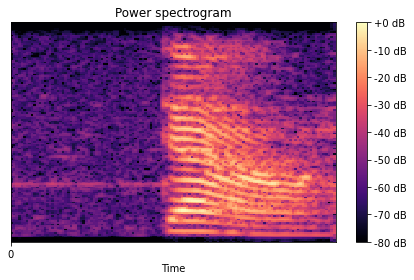

In [8]:
import matplotlib.pyplot as plt
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(specs[2], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

#### - 라벨데이터 처리하기

In [9]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [10]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

In [11]:
label_data.shape

(50620,)

#### - sklearn의 train_test_split함수를 이용하여 train, test 분리

In [12]:
from sklearn.model_selection import train_test_split

xr = specs.shape[1]
yr = specs.shape[2]
train_wav, test_wav, train_label, test_label = train_test_split(specs, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)

train_wav = train_wav.reshape([-1, xr, yr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, xr, yr, 1])

In [13]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (45558, 130, 126, 1)
train labels :  (45558,)
test data :  (5062, 130, 126, 1)
test labels :  (5062,)


### 2. 학습을 위한 하이퍼 파라미터 설정

In [14]:
batch_size = 16
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

checkpoint_dir

'/home/aiffel-dj51/aiffel/speech_recognition/models/wav_skip'

### 3. 데이터셋 구성

In [15]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [16]:
del speech_data
del specs
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


### 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성

In [17]:
from tensorflow.keras import layers
import tensorflow as tf

In [18]:
def plain_model(input_size):
    input_tensor = layers.Input(input_size)

    x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
    x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    output_tensor = layers.Dense(12)(x)

    model_wav = tf.keras.Model(input_tensor, output_tensor)

    model_wav.summary()
    return model_wav

In [19]:
model_wav = plain_model((130, 126, 1))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0     

In [23]:
def skip_model(input_size):
    input_tensor = layers.Input(input_size)

    x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
    x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
    skip_1 = layers.MaxPool2D()(x)

    x = layers.Conv2D(64, 9, padding='same', activation='relu')(skip_1)
    x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
    x = tf.concat([x, skip_1], -1)
    skip_2 = layers.MaxPool2D()(x)

    x = layers.Conv2D(128, 9, padding='same', activation='relu')(skip_2)
    x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
    x = tf.concat([x, skip_2], -1)
    skip_3 = layers.MaxPool2D()(x)

    x = layers.Conv2D(256, 9, padding='same', activation='relu')(skip_3)
    x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
    x = tf.concat([x, skip_3], -1)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    output_tensor = layers.Dense(12)(x)

    model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

    model_wav_skip.summary()
    return model_wav_skip

In [24]:
model_wav_skip = skip_model((130, 126, 1))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 130, 126, 32) 2624        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 130, 126, 32) 82976       conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 65, 63, 32)   0           conv2d_11[0][0]                  
____________________________________________________________________________________________

In [20]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [21]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [22]:
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
2847/2847 [==============================] - ETA: 0s - loss: 0.6638 - accuracy: 0.7833
Epoch 00001: val_loss improved from inf to 0.27034, saving model to /home/aiffel-dj51/aiffel/speech_recognition/models/wav_skip
2847/2847 [==============================] - 288s 101ms/step - loss: 0.6638 - accuracy: 0.7833 - val_loss: 0.2703 - val_accuracy: 0.9142
Epoch 2/10
2847/2847 [==============================] - ETA: 0s - loss: 0.2454 - accuracy: 0.9235 - ETA: 47s - loss: 0. - ETA: 22s - loss: 0.2 - ETA: 20s - loss: 0.2477 - - ETA: 18s - loss: 0.24 - ETA: 16 - ETA:  - ETA: 5s - loss: 0.245 -
Epoch 00002: val_loss improved from 0.27034 to 0.23407, saving model to /home/aiffel-dj51/aiffel/speech_recognition/models/wav_skip
2847/2847 [==============================] - 294s 103ms/step - loss: 0.2454 - accuracy: 0.9235 - val_loss: 0.2341 - val_accuracy: 0.9320
Epoch 3/10
2847/2847 [==============================] - ETA: 0s - loss: 0.1657 - accuracy: 0.9466
Epoch 00003: val_loss improved 

In [25]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [26]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)


In [27]:
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                        steps_per_epoch=len(train_wav) // batch_size,
                        validation_data=test_dataset,
                        validation_steps=len(test_wav) // batch_size,
                        callbacks=[cp_callback]
                        )

Epoch 1/10
2847/2847 [==============================] - ETA: 0s - loss: 0.6492 - accuracy: 0.7889
Epoch 00001: val_loss improved from inf to 0.24629, saving model to /home/aiffel-dj51/aiffel/speech_recognition/models/wav_skip
2847/2847 [==============================] - 316s 111ms/step - loss: 0.6492 - accuracy: 0.7889 - val_loss: 0.2463 - val_accuracy: 0.9217
Epoch 2/10
2847/2847 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.9332
Epoch 00002: val_loss improved from 0.24629 to 0.15300, saving model to /home/aiffel-dj51/aiffel/speech_recognition/models/wav_skip
2847/2847 [==============================] - 321s 113ms/step - loss: 0.2128 - accuracy: 0.9332 - val_loss: 0.1530 - val_accuracy: 0.9492
Epoch 3/10
2847/2847 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.9550
Epoch 00003: val_loss did not improve from 0.15300
2847/2847 [==============================] - 323s 113ms/step - loss: 0.1406 - accuracy: 0.9550 - val_loss: 0.1731 - val_a

### 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

#### -loss, accuracy를 그래프로 표현

#### -Plain model 결과 시각화

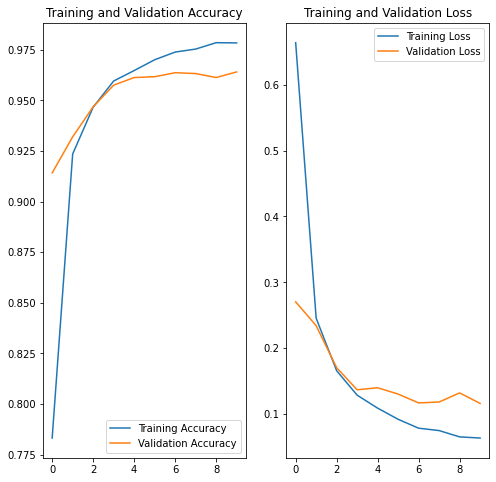

In [28]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### -Skip model 결과 시각화

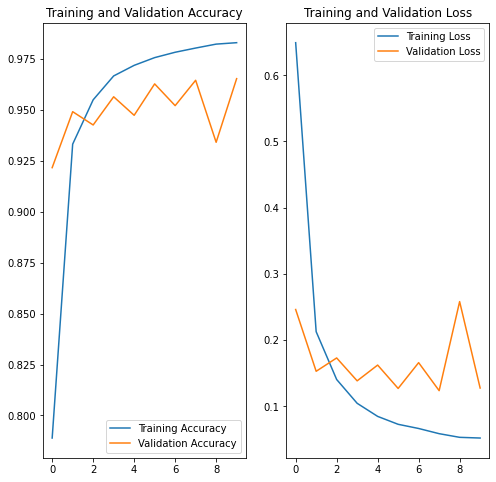

In [29]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 6. Test dataset을 이용해서 모델의 성능을 평가

#### - 저장한 weight 불러오기
#### - 모델의 예측값과 정답값이 얼마나 일치하는지 확인

In [30]:
model_wav.load_weights(checkpoint_dir)
results = model_wav.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5e282f9350> and <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5e29d01c50>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5e29d01c50> and <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5e28367e10>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5e28367e10> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f5e87056e50>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5e28292dd0> and <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5e8705ab10>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D o

ValueError: Shapes (9, 9, 64, 128) and (9, 9, 96, 128) are incompatible

In [31]:
model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))


317/317 [==============================] - 25s 80ms/step - loss: 0.1236 - accuracy: 0.9646
loss value: 0.124
accuracy value: 96.4638%


In [33]:
import IPython.display as ipd

In [34]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

label :  no


In [35]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))

y_pred: no


### 느낀점(회고)
1차원의 데이터를 학습시키는 결과와 비교해서 2차원의 waveform으로 학습시키는 결과가 더 향상된 것을 알 수 있었습니다.